In [ ]:
%matplotlib inline

# Assuming we are in the notebooks directory, we need to move one up:
%cd ..

from __future__ import print_function

import os
import us
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

# North Carolina

In [2]:
state_name = 'NC'
best_path = glob.glob('./clustered/best_stats/' + state_name +'*')[0]
best_basename = os.path.basename(best_path)
filename, file_extension = os.path.splitext(best_basename)
state = gpd.read_file(glob.glob('./clustered/geojson_results/' + filename +'.geojson')[0])

In [3]:
state.head()

,Alpha,Beta,Centroid Latitude,Centroid Longitude,Cluster,Congressional District,GEOID,Predicted 2015 Population,geometry,id
0,2.0,0.6,35.997227,-79.487436,7,06,370010218012010,0.0,"POLYGON ((-79.48484599999999 35.99757, -79.484...",0
1,2.0,0.6,35.999904,-79.478552,7,06,370010218012013,0.0,"POLYGON ((-79.478807 35.999981, -79.478971 35....",1
2,2.0,0.6,36.003135,-79.475675,7,06,370010218012009,0.0,"POLYGON ((-79.474141 36.005681, -79.474081 36....",2
3,2.0,0.6,36.003904,-79.463586,8,06,370010218012001,0.0,"POLYGON ((-79.46624299999999 36.002165, -79.46...",3
4,2.0,0.6,35.968335,-79.524921,7,06,370010218012048,0.0,"POLYGON ((-79.53047099999999 35.966032, -79.53...",4


In [4]:
mini = state[['Predicted 2015 Population', 'geometry', 'Cluster', 'Congressional District', 'GEOID']]

In [5]:
mini['area'] = mini['geometry'].to_crs({'init': 'epsg:3395'}).map(lambda p: p.area / 10**6)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [6]:
# GEOID Structure is defined as
# STATE + COUNTY + TRACT + BLOCK = 2 + 3 + 6 + 4 = 15
# see: https://www.census.gov/geo/reference/geoidentifiers.html
def get_tract(row):
#     print(type(row['GEOID']))
    return row['GEOID'][5:11]
mini['Tract'] = mini.apply(get_tract, axis=1)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
tracts = mini.dissolve(by='Tract')

In [8]:
tracts.head()

,geometry,Predicted 2015 Population,Cluster,Congressional District,GEOID,area
Tract,,,,,,
000100,"(POLYGON ((-80.84199599999999 35.220125, -80.8...",0.000000,1,10,370210001001031,0.016909
000101,"(POLYGON ((-78.876755 36.013599, -78.877118 36...",0.000000,8,01,370630001011029,0.017904
000102,"(POLYGON ((-78.89038599999999 36.01516, -78.89...",78.913333,8,01,370630001022015,0.121920
000103,"POLYGON ((-77.3103 34.768795, -77.310989999999...",42.415305,5,03,371330001031024,1.677060
000200,"(POLYGON ((-78.892566 35.020198, -78.89264 35....",11.979339,1,10,370210002002017,0.034104


In [9]:
mini = mini[['Predicted 2015 Population', 'area', 'Tract']]

In [10]:
mini.head()

,Predicted 2015 Population,area,Tract
0,0.0,0.019462,021801
1,0.0,0.007747,021801
2,0.0,0.024062,021801
3,0.0,0.020475,021801
4,0.0,0.692909,021801


In [11]:
pop = mini.groupby('Tract').sum()
pop['Tract'] = pop.index
pop.head()

,Predicted 2015 Population,area,Tract
Tract,,,
000100,16111.0,15.656931,000100
000101,10018.0,214.334518,000101
000102,20170.0,192.327918,000102
000103,6232.0,560.199988,000103
000200,12128.0,209.324685,000200


In [12]:
del tracts['Predicted 2015 Population']

In [13]:
del tracts['area']

In [14]:
tracts['Tract'] = tracts.index

In [15]:
tracts.head()

,geometry,Cluster,Congressional District,GEOID,Tract
Tract,,,,,
000100,"(POLYGON ((-80.84199599999999 35.220125, -80.8...",1,10,370210001001031,000100
000101,"(POLYGON ((-78.876755 36.013599, -78.877118 36...",8,01,370630001011029,000101
000102,"(POLYGON ((-78.89038599999999 36.01516, -78.89...",8,01,370630001022015,000102
000103,"POLYGON ((-77.3103 34.768795, -77.310989999999...",5,03,371330001031024,000103
000200,"(POLYGON ((-78.892566 35.020198, -78.89264 35....",1,10,370210002002017,000200


In [16]:
tracts = tracts.merge(pop, on='Tract')

In [17]:
tracts['Population per square km'] = tracts['Predicted 2015 Population'] / tracts['area'] 

In [18]:
tracts.head()

,geometry,Cluster,Congressional District,GEOID,Tract,Predicted 2015 Population,area,Population per square km
0,"(POLYGON ((-80.84199599999999 35.220125, -80.8...",1,10,370210001001031,000100,16111.0,15.656931,1029.001128
1,"(POLYGON ((-78.876755 36.013599, -78.877118 36...",8,01,370630001011029,000101,10018.0,214.334518,46.740022
2,"(POLYGON ((-78.89038599999999 36.01516, -78.89...",8,01,370630001022015,000102,20170.0,192.327918,104.872970
3,"POLYGON ((-77.3103 34.768795, -77.310989999999...",5,03,371330001031024,000103,6232.0,560.199988,11.124599
4,"(POLYGON ((-78.892566 35.020198, -78.89264 35....",1,10,370210002002017,000200,12128.0,209.324685,57.938699


In [19]:
tracts.to_file('./fig/shapefile/results/pop_' + state_name + '_by_tract.shp', driver="ESRI Shapefile")

# Iowa

In [20]:
state_name = 'IA'
best_path = glob.glob('./clustered/best_stats/' + state_name +'*')[0]
best_basename = os.path.basename(best_path)
filename, file_extension = os.path.splitext(best_basename)
state = gpd.read_file(glob.glob('./clustered/geojson_results/' + filename +'.geojson')[0])

In [21]:
mini = state[['Predicted 2015 Population', 'geometry', 'Cluster', 'Congressional District', 'GEOID']]

In [22]:
mini['area'] = mini['geometry'].to_crs({'init': 'epsg:3395'}).map(lambda p: p.area / 10**6)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [23]:
# GEOID Structure is defined as
# STATE + COUNTY + TRACT + BLOCK = 2 + 3 + 6 + 4 = 15
# see: https://www.census.gov/geo/reference/geoidentifiers.html
def get_tract(row):
#     print(type(row['GEOID']))
    return row['GEOID'][5:11]
mini['Tract'] = mini.apply(get_tract, axis=1)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
tracts = mini.dissolve(by='Tract')

In [25]:
mini = mini[['Predicted 2015 Population', 'area', 'Tract']]

In [26]:
pop = mini.groupby('Tract').sum()
pop['Tract'] = pop.index

In [27]:
del tracts['Predicted 2015 Population']

In [28]:
del tracts['area']

In [29]:
tracts['Tract'] = tracts.index
tracts = tracts.merge(pop, on='Tract')
tracts['Population per square km'] = tracts['Predicted 2015 Population'] / tracts['area'] 
tracts.to_file('./fig/shapefile/results/pop_' + state_name + '_by_tract.shp', driver="ESRI Shapefile")

# Major Cities in NC and IA

In [33]:
cities = gpd.read_file('./fig/shapefile/citiesx010g_shp_nt00962/citiesx010g.shp')
# From: https://catalog.data.gov/dataset/usgs-small-scale-dataset-cities-and-towns-of-the-united-states-201403-shapefile

In [34]:
cities.head()

,ANSICODE,COUNTY,COUNTYFIPS,ELEV_IN_FT,ELEV_IN_M,FEATURE,FEATURE2,GNIS_ID,LATITUDE,LONGITUDE,NAME,POP_2010,PopPlLat,PopPlLong,STATE,STATE_FIPS,geometry
0,1036000,Rolette,079,1706.0,520.0,Civil,-999,1028750.0,48.813057,-100.060968,Dunseith,773.0,48.813057,-100.060968,ND,38,POINT (-100.0609678 48.81305690000016)
1,1036174,Rolette,079,1654.0,504.0,Civil,-999,1030349.0,48.635278,-99.618756,Mylo,20.0,48.635278,-99.618756,ND,38,POINT (-99.61875549999991 48.63527850000003)
2,1035912,Bottineau,009,1535.0,468.0,Civil,-999,1027718.0,48.970853,-101.282380,Antler,27.0,48.970853,-101.282380,ND,38,POINT (-101.2823802999999 48.97085320000008)
3,1035936,Bottineau,009,1637.0,499.0,Civil,County Seat,1028083.0,48.827230,-100.445698,Bottineau,2211.0,48.827230,-100.445698,ND,38,POINT (-100.4456984 48.82723010000012)
4,1036050,Bottineau,009,1467.0,447.0,Civil,-999,1029080.0,48.700837,-100.497639,Gardena,29.0,48.700837,-100.497639,ND,38,POINT (-100.4976392999999 48.70083700000004)


In [37]:
nc_ia_cities = cities[(cities['STATE'] == 'NC') | (cities['STATE'] == 'IA')]

In [38]:
nc_ia_cities = nc_ia_cities[(nc_ia_cities['NAME'] == 'Des Moines') | (nc_ia_cities['NAME'] == 'Cedar Rapids') | \
                            (nc_ia_cities['NAME'] == 'Charlotte') | (nc_ia_cities['NAME'] == 'Raleigh')]

In [41]:
nc_ia_cities = nc_ia_cities[nc_ia_cities['POP_2010'] > 1000]

In [42]:
nc_ia_cities.head()

,ANSICODE,COUNTY,COUNTYFIPS,ELEV_IN_FT,ELEV_IN_M,FEATURE,FEATURE2,GNIS_ID,LATITUDE,LONGITUDE,NAME,POP_2010,PopPlLat,PopPlLong,STATE,STATE_FIPS,geometry
471,467567,Linn,113,810.0,247.0,Civil,County Seat,465941.0,42.008333,-91.644068,Cedar Rapids,126326.0,42.008333,-91.644068,IA,19,POINT (-91.64406829999996 42.00833280000012)
7069,2394522,Polk,153,873.0,266.0,Civil,State Capital County Seat,465961.0,41.600545,-93.609106,Des Moines,203433.0,41.600545,-93.609106,IA,19,POINT (-93.60910639999997 41.60054480000008)
14497,2404590,Wake,183,315.0,96.0,Civil,State Capital County Seat,1024242.0,35.772096,-78.638615,Raleigh,403892.0,35.772096,-78.638615,NC,37,POINT (-78.63861449999996 35.77209600000009)
14557,2404032,Mecklenburg,119,761.0,232.0,Civil,County Seat,1019610.0,35.227087,-80.843127,Charlotte,731424.0,35.227087,-80.843127,NC,37,POINT (-80.84312679999994 35.22708690000007)


In [43]:
nc_ia_cities.to_file('./fig/shapefile/cities/nc_ia_cities.shp', driver="ESRI Shapefile")

# Confressional Districts for NC and IA

In [3]:
from default_values import usa_shapefile_path
usa = gpd.read_file(usa_shapefile_path)

In [4]:
az_ne_cong_dist = usa[(usa['STATEFP'].apply(int) == int(us.states.lookup('NC').fips)) |
    (usa['STATEFP'].apply(int) == int(us.states.lookup('IA').fips))]

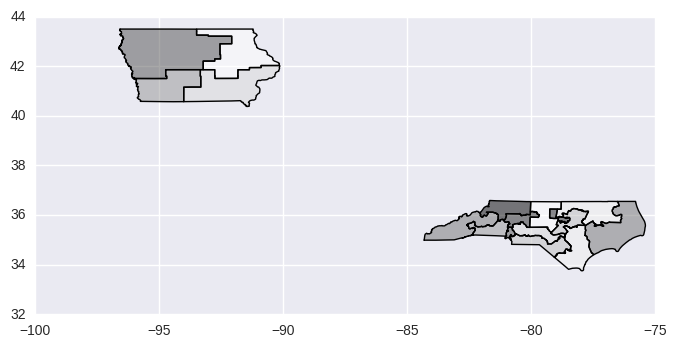

In [5]:
az_ne_cong_dist.plot()

In [6]:
az_ne_cong_dist.to_file('./fig/shapefile/cong_dist/nc_ia_cong_dist.shp', driver="ESRI Shapefile")

# Clusters for NC and IA

In [48]:
state_name = 'NC'
best_path = glob.glob('./clustered/best_stats/' + state_name +'*')[0]
best_basename = os.path.basename(best_path)
filename, file_extension = os.path.splitext(best_basename)
state = gpd.read_file(glob.glob('./clustered/geojson_results/' + filename +'.geojson')[0])

In [49]:
north_carolina = state.dissolve(by='Cluster')

In [50]:
north_carolina.to_file('./fig/shapefile/results/north_carolina.shp', driver="ESRI Shapefile")

In [51]:
state_name = 'IA'
best_path = glob.glob('./clustered/best_stats/' + state_name +'*')[0]
best_basename = os.path.basename(best_path)
filename, file_extension = os.path.splitext(best_basename)
state = gpd.read_file(glob.glob('./clustered/geojson_results/' + filename +'.geojson')[0])
iowa = state.dissolve(by='Cluster')
iowa.to_file('./fig/shapefile/results/iowa.shp', driver="ESRI Shapefile")